In [1]:
# Notebook 01 : Préparation & Feature Engineering - Projet 5G mmWave

## 📥 1. Imports & Chargement des données

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Chemin local du dataset
file_path = "D:\\4DATA\SEMESTER2\PI\DATASET\mm-5G.csv"
df = pd.read_csv(file_path, sep=',')

# Aperçu des données
print("\nHead:")
df.head()


Head:


<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Souhayl\AppData\Local\Temp\ipykernel_6620\1730862091.py:8: SyntaxWarning: invalid escape sequence '\S'
  file_path = "D:\\4DATA\SEMESTER2\PI\DATASET\mm-5G.csv"


,run_num,seq_num,abstractSignalStr,latitude,longitude,movingSpeed,compassDirection,nrStatus,lte_rssi,lte_rsrp,lte_rsrq,lte_rssnr,nr_ssRsrp,nr_ssRsrq,nr_ssSinr,Throughput,mobility_mode,trajectory_direction,tower_id
0,1,1.0,2,44.975314,-93.259316,0.094889,150,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,78,driving,CW,16
1,1,2.0,2,44.975311,-93.259311,0.876634,117,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,117,driving,CW,16
2,1,3.0,2,44.975305,-93.259292,2.225798,113,NOT_RESTRICTED,-61.0,-94,-14.0,2.147484e+09,NaN,NaN,NaN,110,driving,CW,16
3,1,4.0,2,44.975293,-93.259258,3.180726,114,NOT_RESTRICTED,-59.0,-95,-16.0,2.147484e+09,NaN,NaN,NaN,108,driving,CW,16
4,1,5.0,2,44.975278,-93.259214,3.751234,115,NOT_RESTRICTED,-59.0,-95,-16.0,2.147484e+09,NaN,NaN,NaN,100,driving,CW,16


## 🧹 2. Nettoyage des données manquantes

In [3]:
# LTE : remplacer NaN par médiane
lte_cols = ['lte_rssi', 'lte_rsrp', 'lte_rsrq', 'lte_rssnr']
for col in lte_cols:
    df[col] = df[col].fillna(df[col].median())

# NR : remplacer NaN par 0
nr_cols = ['nr_ssRsrp', 'nr_ssRsrq', 'nr_ssSinr']
df[nr_cols] = df[nr_cols].fillna(0)

## 🔤 3. Encodage des variables catégorielles

In [4]:
cat_cols = ['nrStatus', 'mobility_mode', 'trajectory_direction', 'tower_id']
for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col].astype(str))

## 🧠 4. Feature Engineering hybride : brut + lissé + delta

In [5]:
df['debit_brut'] = df['Throughput']
df['debit_lisse'] = df['Throughput'].ewm(span=8, adjust=False).mean()
df['delta'] = df['debit_brut'] - df['debit_lisse']
df['variation_relative'] = df['delta'] / (df['debit_lisse'] + 1e-6)
df['slope_brut'] = df['debit_brut'].diff()
df['slope_lisse'] = df['debit_lisse'].diff()

## 🧮 5. Classification du débit : Low / Medium / High

In [11]:
bins = [0, 300, 700, np.inf]
labels = ['Low', 'Medium', 'High']
df['debit_class'] = pd.cut(df['debit_lisse'], bins=bins, labels=labels)

## 🚨 6. Détection d’anomalies avec seuil dynamique

In [7]:
window = 15
df['seuil'] = df['delta'].rolling(window=window).std() * 1.5
df['is_anomaly'] = (df['delta'].abs() > df['seuil']).astype(int)

## 📊 7. Visualisation des résultats (Run 4 avec index)

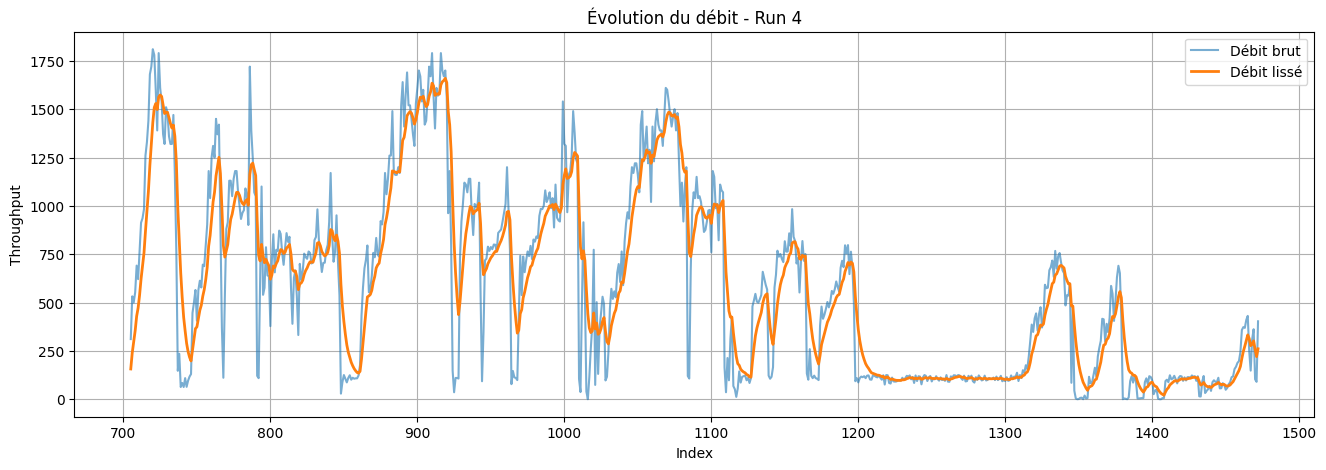

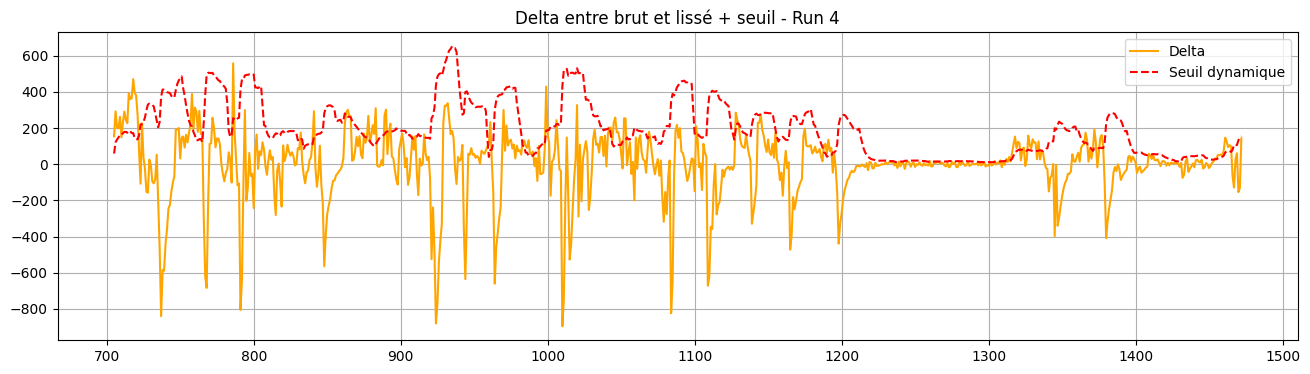

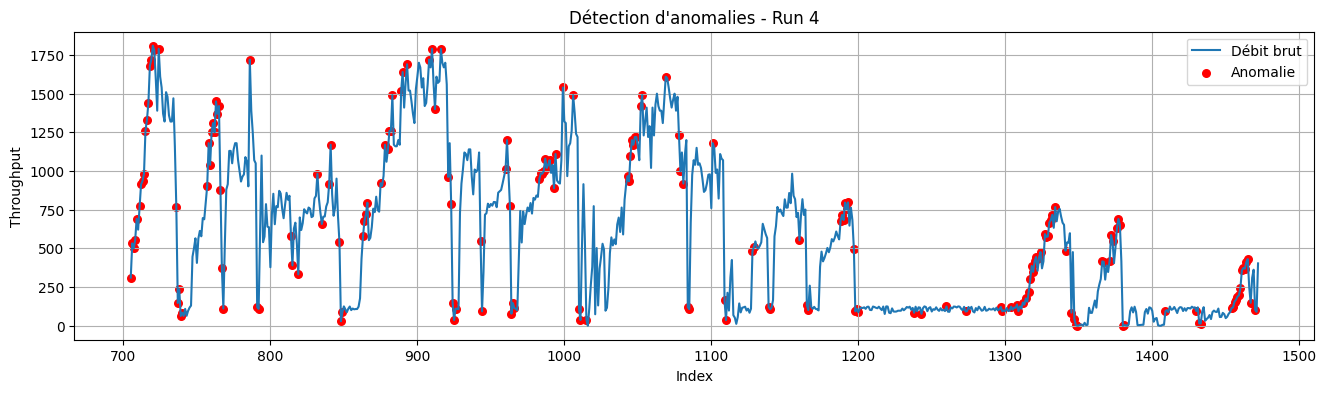

In [8]:
# Visualisation pour le run numéro 4
run_num = 4

if 'run_num' in df.columns:
    df_run = df[df['run_num'] == run_num]
else:
    df_run = df.copy()
    print("⚠️ Colonne 'run_num' non trouvée, visualisation sur l'ensemble des données.")

plt.figure(figsize=(16,5))
plt.plot(df_run.index, df_run['debit_brut'], label='Débit brut', alpha=0.6)
plt.plot(df_run.index, df_run['debit_lisse'], label='Débit lissé', linewidth=2)
plt.title(f"Évolution du débit - Run {run_num}")
plt.xlabel("Index")
plt.ylabel("Throughput")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(df_run.index, df_run['delta'], label='Delta', color='orange')
plt.plot(df_run.index, df_run['seuil'], label='Seuil dynamique', linestyle='--', color='red')
plt.title(f"Delta entre brut et lissé + seuil - Run {run_num}")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16,4))
plt.plot(df_run.index, df_run['debit_brut'], label='Débit brut')
plt.scatter(df_run[df_run['is_anomaly'] == 1].index,
            df_run[df_run['is_anomaly'] == 1]['debit_brut'],
            color='red', label='Anomalie', s=30)
plt.title(f"Détection d'anomalies - Run {run_num}")
plt.xlabel("Index")
plt.ylabel("Throughput")
plt.legend()
plt.grid(True)
plt.show()

## 🔍 8. Aperçu final du DataFrame enrichi

In [10]:
print("\nAperçu des nouvelles colonnes :")
df[['debit_brut', 'debit_lisse', 'delta', 'seuil', 'is_anomaly', 'debit_class']].head(10)


Aperçu des nouvelles colonnes :


,debit_brut,debit_lisse,delta,seuil,is_anomaly,debit_class
0,78,78.000000,0.000000,NaN,0,Low
1,117,86.666667,30.333333,NaN,0,Low
2,110,91.851852,18.148148,NaN,0,Low
3,108,95.440329,12.559671,NaN,0,Low
4,100,96.453589,3.546411,NaN,0,Low
5,124,102.575014,21.424986,NaN,0,Low
6,109,104.002789,4.997211,NaN,0,Low
7,108,104.891058,3.108942,NaN,0,Low
8,87,100.915267,-13.915267,NaN,0,Low
9,116,104.267430,11.732570,NaN,0,Low
